## ECSE 415, Assignment 4 

 
 It is advised to run parts in order as there might be a result of very low accuracy for each subpart otherwise. 
 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

In [2]:
# Library used from the link provided
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [3]:
# Used latin1 to turn the data from byte to some reasonable shapes.
# Saving the pictures with their lables into variables.

batch5 = unpickle('cifar-10-batches-py/data_batch_5')
batchesMeta = unpickle('cifar-10-batches-py/batches.meta')


## Part 1

QUESTION 1: Use any one random data batch and convert it into images of size 32x32x3 and display at least 10 images from each class along with their class label. (Use Fig:1 as an example)

airplane


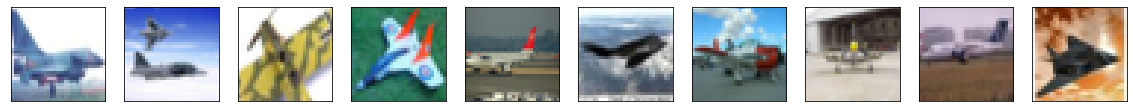

automobile


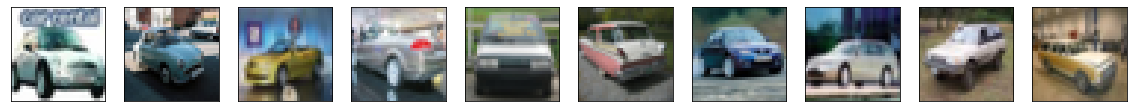

bird


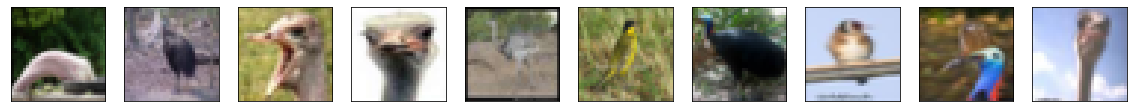

cat


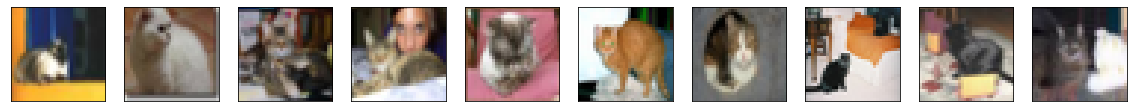

deer


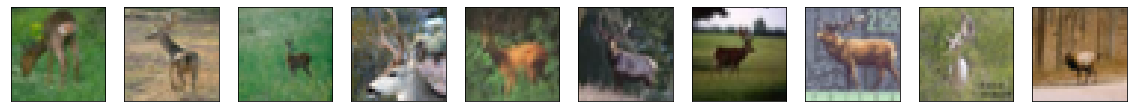

dog


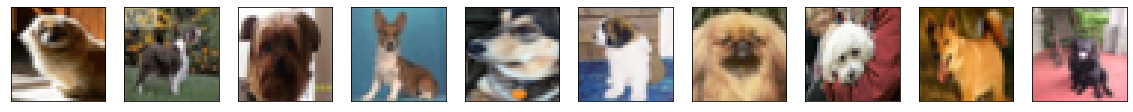

frog


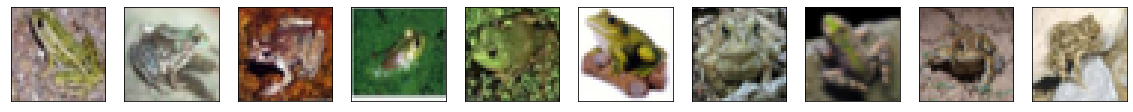

horse


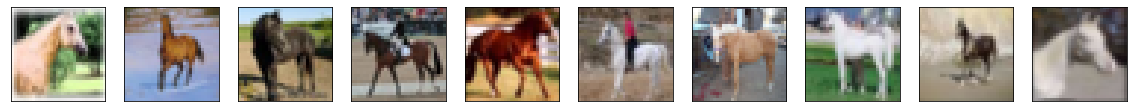

ship


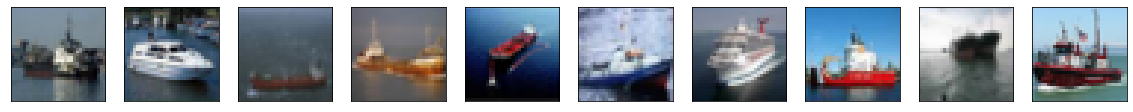

truck


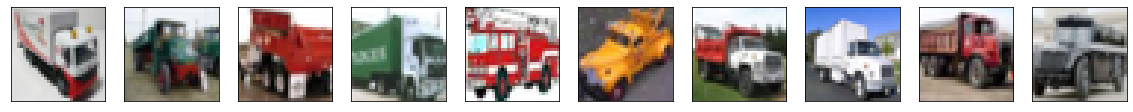

In [4]:
# Reading images from batch5
data_batch5 = batch5["data"]
label_batch5 = batch5["labels"]
labelTitle = batchesMeta["label_names"]

# Reshape Images
data_batch5 = np.reshape(data_batch5, (10000, 3, 32, 32))
data_batch5 = data_batch5.transpose(0, 2, 3, 1)

#i = total classes
for i in range(10):
    print (labelTitle[i])
    
    # If the item matches the category (car, bird,...), 
    #then save the index of the image
    imagesIndx = []
    for index, item in enumerate(label_batch5):
        if (item == i):
            imagesIndx.append(index)
    
    # Plotting the graphs
    plt.figure(figsize=(20,20))
    for k in range(10):
        plt.subplot(1, 10, k + 1)
        plt.imshow(data_batch5[imagesIndx[k]])
        plt.xticks([]), plt.yticks([])
    plt.show()

## Part 2 

In [5]:
# Initiating sizez and orientation
cell_size = (8, 8)
block_size = (2, 2)
nbins = 9


# This part is used from tutorial
def hog_features(images):
    
    hog_features = []
    
    for img in images:
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
        
        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
        
        hog_feats = hog.compute(img) \
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[1], block_size[0], nbins) \
               .transpose((1, 0, 3, 2, 4)).flatten()
        
        hog_features.append(hog_feats)
    
    hog_features = np.vstack(hog_features)
    
    return hog_features 

# calculating the average RGB intensity for each image
def mean_intensity(images):
    
    rows = 32
    columns = 32
    meanRed = 0
    meanBlue = 0
    meanGreen = 0
    
    mean_intensity = np.ndarray(shape=(10000, 3))
    
    for i in range(len(images)):
        for row in range(32):
            for column in range(32):
                meanRed += images[i][row][column][0]
                meanBlue += images[i][row][column][1]
                meanGreen += images[i][row][column][2]
        
        meanRed = int(meanRed/1024)
        meanBlue = int(meanBlue/1024)
        meanGreen = int(meanGreen/1024)
        
        mean_intensity[i][0] = meanRed
        mean_intensity[i][1] = meanBlue
        mean_intensity[i][2] = meanGreen
    
    return mean_intensity 


# The number of correct predictions divided by the total predictions
def accuracy(predictions, actual):
    count = 0
    for i in range(len(predictions)):
        if (predictions[i] == actual[i]):
            count += 1
    return count/(len(predictions))


QUESTION 2.1: Extract the two different features and train two different linear SVMs (one for each feature) on the training set. Use gamma=’scale’ and keep other hyper- parameters as default. Which features give better results (in terms of the performance metrics)? Is it expected? Give a hypothetical scenario (i.e. image dataset) in which both feature extraction method can work well for classification?

    HoG features gives better results . Because the confusion matrix is more diagonal and it has higher accuracy (with around 0.3 increase in accuracy).
    It is expected as HoGs can capture local appearance and shapes by magnitude weighed gradient orientation within an image.
    As an example for the last question: we're having am image of a blue balloon and a red kite, both HoG and mean RGB will work well because their color and shape are distinct.

In [6]:
# used batch 1 as an example for both linear and non-linear SVM.

batch1 = unpickle('cifar-10-batches-py/data_batch_1')
batch1Data = batch1["data"]
batch1Labels = batch1["labels"]

# Reshaping data
batch1Data = np.reshape(batch1Data, (10000, 3, 32, 32))
batch1Data = batch1Data.transpose(0, 2, 3, 1)

testBatch = unpickle('cifar-10-batches-py/test_batch')
testBatchData = testBatch["data"]
testBatchLabels = testBatch["labels"]

# Reshaping test data
testBatchData = np.reshape(testBatchData, (10000, 3, 32, 32))
testBatchData = testBatchData.transpose(0, 2, 3, 1)

Hog_features = hog_features(batch1Data)
HogTestFeatures = hog_features(testBatchData)

Mean_features = mean_intensity(batch1Data)
MeanTestFeatures = mean_intensity(testBatchData)


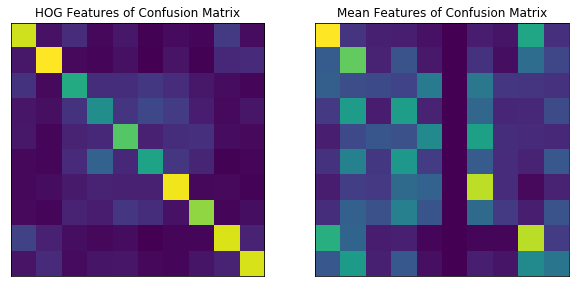

Hog Features Accuracy: 0.5381
Mean Features Accuracy: 0.2407


In [7]:
#Linear SVMs

clf1 = svm.SVC(gamma='scale', kernel='linear')
clf2 = svm.SVC(gamma='scale', kernel='linear')

clf1.fit(Hog_features, batch1Labels)
clf2.fit(Mean_features, batch1Labels)

predictions_hog = clf1.predict(HogTestFeatures)
predictions_mean = clf2.predict(MeanTestFeatures)

conf_hog = confusion_matrix(testBatchLabels, predictions_hog)
conf_mean = confusion_matrix(testBatchLabels, predictions_mean)

# mean features for confusion matrix usually gives poor results. However, the rest of the figures have slightly 
# more accurate resutls.


# Plotting figures
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(conf_hog)
plt.title("HOG Features of Confusion Matrix"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(conf_mean)
plt.title("Mean Features of Confusion Matrix"), plt.xticks([]), plt.yticks([])
plt.show()


# Printing accuracies
print ("Hog Features Accuracy: " + str(accuracy(predictions_hog, testBatchLabels)))
print ("Mean Features Accuracy: " + str(accuracy(predictions_mean, testBatchLabels)))


QUESTION 2.2: Extract HoG features, and train two different SVM classifiers with two different kernels: (i) Polynomial (ii) Radial Basis Function (RBF). Use gamma=’scale’ and keep other hyperparameters as default. Compare the accuracy of these two with linear SVM. Which one is giving better results? Is it expected? 

    RBF Kernel is better than polynomial. Both are better than linear SVM and the result satisfies the expectation.

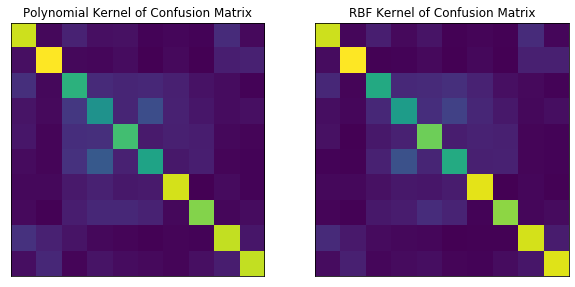

Hog Features Polynomial Kernel Accuracy: 0.5872
Hog Features RBF Kernel Accuracy: 0.6138


In [8]:
# Non-linear SVMs

clf3 = svm.SVC(gamma='scale', kernel='poly')
clf4 = svm.SVC(gamma='scale', kernel='rbf')

#Training
clf3.fit(Hog_features, batch1Labels)
clf4.fit(Hog_features, batch1Labels)

predictions_poly_hog = clf3.predict(HogTestFeatures)
predictions_rbf_hog = clf4.predict(HogTestFeatures)


conf_poly_hog = confusion_matrix(testBatchLabels, predictions_poly_hog)
conf_rbf_hog = confusion_matrix(testBatchLabels, predictions_rbf_hog)


# Plotting figures
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(conf_poly_hog)
plt.title("Polynomial Kernel of Confusion Matrix"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(conf_rbf_hog)
plt.title("RBF Kernel of Confusion Matrix"), plt.xticks([]), plt.yticks([])
plt.show()

# Printing accuracies
print ("Hog Features Polynomial Kernel Accuracy: " + str(accuracy(predictions_poly_hog, testBatchLabels)))
print ("Hog Features RBF Kernel Accuracy: " + str(accuracy(predictions_rbf_hog, testBatchLabels)))


## Part 3

QUESTION 3.1: Extract HoG features, and train a Random Forest classifier of scikit-learn with following parameters: n estimators=100, criterion = ’entropy’. Keep all other parameters to default. Report the performance of the classifier.

Hog Features Random Forest Accuracy: 0.523


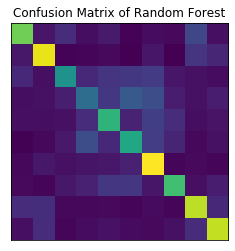

In [9]:
clf_rf = RandomForestClassifier(n_estimators=100, criterion='entropy')

clf_rf.fit(Hog_features, batch1Labels)

predictions_rf = clf_rf.predict(HogTestFeatures)

conf_rf = confusion_matrix(testBatchLabels, predictions_rf)

# Plotting figure
plt.figure()
plt.title("Confusion Matrix of Random Forest"), plt.xticks([]), plt.yticks([])
plt.imshow(conf_rf)

# Printing accuracy
print ("Hog Features Random Forest Accuracy: " + str(accuracy(predictions_rf, testBatchLabels)))



QUESTION 3.2: Extract HoG features, and train RF classifiers with different number of trees (try at least 3 experiments with tress = 40, 200, 250). Write your observations. Do you see an increase in classification performance with an increase in the number of trees? Report the number of trees for which RF gives the best performance.

    it is observed that the higher number of trees would give better performance ( in this case 250 trees, however 200 and 250 trees almost have the same results).
    Each tree will give a class prediction based on random subset of training data and random subset of features. The final result of the random forest is achieved by the most common vote.
    As mentioned earlier the more number of tree will give a more accurate result with confusion matrix that is more diagonal and the reason is that with more trees expected variance will decrease and there will be a lower chance for unseen training data.

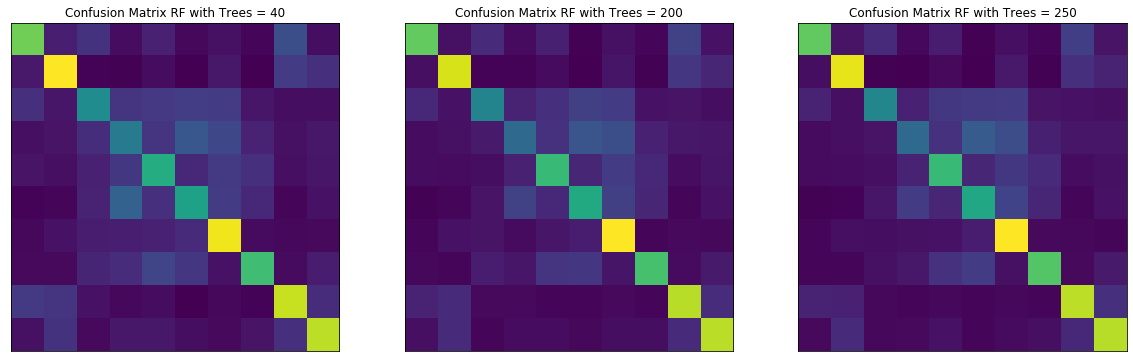

Hog Features RF with Trees = 40 Accuracy: 0.4758
Hog Features RF with Trees = 200 Accuracy: 0.533
Hog Features RF with Trees = 250 Accuracy: 0.5378


In [10]:
# RF with 40 trees

clf_rf_40 = RandomForestClassifier(n_estimators=40, criterion='entropy')

clf_rf_40.fit(Hog_features, batch1Labels)

predictions_rf_40 = clf_rf_40.predict(HogTestFeatures)

conf_rf_40 = confusion_matrix(testBatchLabels, predictions_rf_40)


# RF with 200 trees

clf_rf_200 = RandomForestClassifier(n_estimators=200, criterion='entropy')

clf_rf_200.fit(Hog_features, batch1Labels)

predictions_rf_200 = clf_rf_200.predict(HogTestFeatures)

conf_rf_200 = confusion_matrix(testBatchLabels, predictions_rf_200)


# RF with 250 trees

clf_rf_250 = RandomForestClassifier(n_estimators=250, criterion='entropy')

clf_rf_250.fit(Hog_features, batch1Labels)

predictions_rf_250 = clf_rf_250.predict(HogTestFeatures)

conf_rf_250 = confusion_matrix(testBatchLabels, predictions_rf_250)


# Display figures
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(conf_rf_40)
plt.title("Confusion Matrix RF with Trees = 40"),
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(conf_rf_200)
plt.title("Confusion Matrix RF with Trees = 200"),
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(conf_rf_250)
plt.title("Confusion Matrix RF with Trees = 250"),
plt.xticks([]), plt.yticks([])
plt.show()


# Print Accuracy results
print ("Hog Features RF with Trees = 40 Accuracy: " + str(accuracy(predictions_rf_40, testBatchLabels)))
print ("Hog Features RF with Trees = 200 Accuracy: " + str(accuracy(predictions_rf_200, testBatchLabels)))
print ("Hog Features RF with Trees = 250 Accuracy: " + str(accuracy(predictions_rf_250, testBatchLabels)))


## Part 4

QUESTION 4.1: Describe the performance and the best performing RF classifier (number of trees) and SVM (type of kernel) from the previous sections. Compare both accuracy and Confusion matrices for both classifiers on both training and testing sets. Write your observations. Is there any particular class which is hard to classify for SVM but easier for RF or vice versa?

    RF with number of trees more than 200 is better and RBF kernel is the best for SVM.
    RF has an approximate full accuracy for train set. That is to say if we have trained RBF SVM.
    By looking at the results of accuracies, we noticed that best performing RF (trees = 250) has an accuracy of 0.5366 while best performing SVM (RBF) has an accuracy of 0.6138 therefore SVM is outperforming RF. I did not face with difficulty to classify SVM classes compared to RF. 

QUESTION 4.2: Change the cell size, block size, and orientation bins for the HoG features. Try experiments with either SVM (best performing kernel) or RF (best performing trees). Report results for at least 3 different experiments. 

1) cell=(4, 4), block=(2, 2), bins=9
   Accuracy of Hog Features RBF Kernel: 0.6138


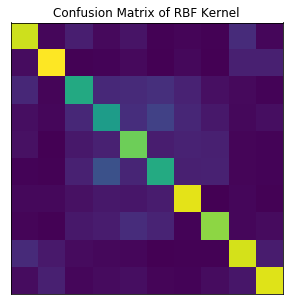

2) cell=(4, 4), block=(4, 4), bins=9
   Accuracy of Hog Features RBF Kernel: 0.5381


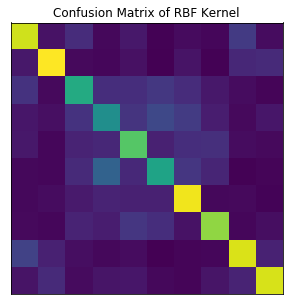

3) cell=(8, 8), block=(2, 2), bins=5
   Accuracy of Hog Features RBF Kernel: 0.5872


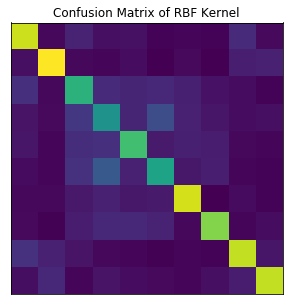

In [11]:
# Using SVM RBF Kernel (better)

# 1) 4, 2, 9
cell_size = (4, 4)
block_size = (2, 2)
nbins = 9

clf1 = svm.SVC(gamma='scale', kernel='rbf')

#Training
clf1.fit(Hog_features, batch1Labels)

predictions_rbf_hog = clf1.predict(HogTestFeatures)

conf_rbf_hog = confusion_matrix(testBatchLabels, predictions_rbf_hog)

print ("1) cell=(4, 4), block=(2, 2), bins=9")
print ("   Accuracy of Hog Features RBF Kernel: " + str(accuracy(predictions_rbf_hog, testBatchLabels)))

plt.figure(figsize=(5,5))
plt.imshow(conf_rbf_hog)
plt.title("Confusion Matrix of RBF Kernel"), plt.xticks([]), plt.yticks([])
plt.show()




# 2) 4, 4, 9
cell_size = (4, 4)
block_size = (4, 4)
nbins = 9

clf1 = svm.SVC(gamma='scale', kernel='rbf')

#Training
clf2.fit(Hog_features, batch1Labels)

predictions_rbf_hog = clf2.predict(HogTestFeatures)

conf_rbf_hog = confusion_matrix(testBatchLabels, predictions_rbf_hog)

print ("2) cell=(4, 4), block=(4, 4), bins=9")
print ("   Accuracy of Hog Features RBF Kernel: " + str(accuracy(predictions_rbf_hog, testBatchLabels)))

plt.figure(figsize=(5,5))
plt.imshow(conf_rbf_hog)
plt.title("Confusion Matrix of RBF Kernel"), plt.xticks([]), plt.yticks([])
plt.show()




# 3) 8, 2, 5
cell_size = (8, 8)
block_size = (2, 2)
nbins = 5

clf1 = svm.SVC(gamma='scale', kernel='rbf')

#Training
clf3.fit(Hog_features, batch1Labels)

predictions_rbf_hog = clf3.predict(HogTestFeatures)

conf_rbf_hog = confusion_matrix(testBatchLabels, predictions_rbf_hog)

print ("3) cell=(8, 8), block=(2, 2), bins=5")
print ("   Accuracy of Hog Features RBF Kernel: " + str(accuracy(predictions_rbf_hog, testBatchLabels)))

plt.figure(figsize=(5,5))
plt.imshow(conf_rbf_hog)
plt.title("Confusion Matrix of RBF Kernel"), plt.xticks([]), plt.yticks([])
plt.show()


QUESTION 4.3: Take best performing HoG feature parameters, SVM (best performing kernel), and RF (best performing trees) from the previous section and do 3 fold validation on any 3 different training batches (data batch 1 - data batch 5). Report accuracies for each fold on the test set for both SVM and RF. Do you see higher accuracy for any particular fold? If yes, what might be the reason.

    All three folds have around the same accuracy. However, SVM RBF for batch 5 would give a slightly better results beacause it has a more diagonal shape and higher accuracy result.

Accuracy for RBF Kernel SVM, batch3 : 0.5914
Accuracy for RF with Trees = 250, batch3 : 0.5202


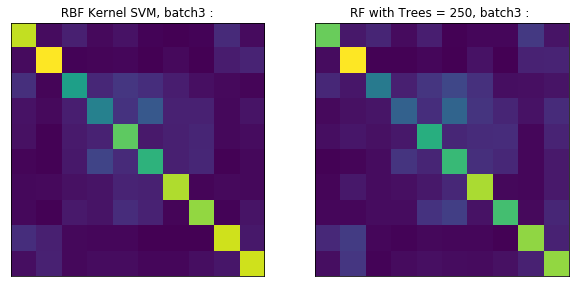

Accuracy for RBF Kernel SVM, batch4 : 0.5961
Accuracy for RF with Trees = 250, batch4 : 0.5189


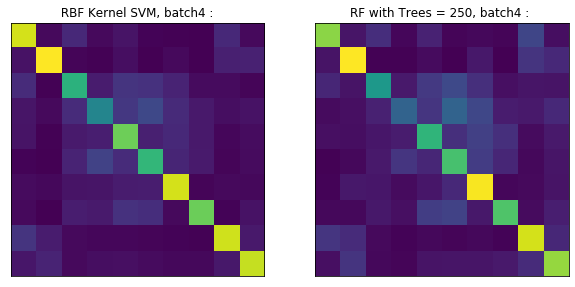

Accuracy for RBF Kernel SVM, batch5 : 0.598
Accuracy for RF with Trees = 250, batch5 : 0.5246


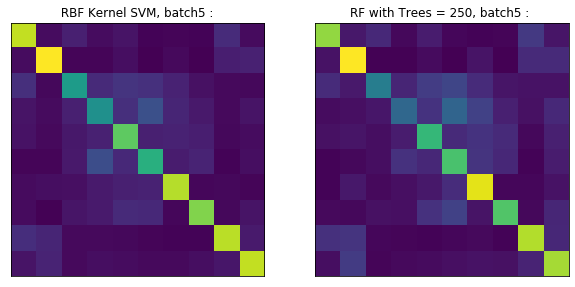

In [12]:
# ------------------------ RBF Kernel, 250 trees, batches 3, 4, 5 -----------------------

predictionArray = []

for batch in range(3,6):
    batchId = unpickle('cifar-10-batches-py/data_batch_'+str(batch))


    batchIdData = batchId["data"]
    batchIdLabels = batchId["labels"]
    # Reshaping
    batchIdData = np.reshape(batchIdData, (10000, 3, 32, 32))
    batchIdData = batchIdData.transpose(0, 2, 3, 1)

    testBatch = unpickle('cifar-10-batches-py/test_batch')
    testBatchData = testBatch["data"]
    testBatchLabels = testBatch["labels"]
    # Reshaping
    testBatchData = np.reshape(testBatchData, (10000, 3, 32, 32))
    testBatchData = testBatchData.transpose(0, 2, 3, 1)

    Hog_features = hog_features(batchIdData)
    HogTestFeatures = hog_features(testBatchData)

    Mean_features = mean_intensity(batchIdData)
    MeanTestFeatures = mean_intensity(testBatchData)


    # # RBF SVM
    clf4 = svm.SVC(gamma='scale', kernel='rbf')

    #Training
    clf4.fit(Hog_features, batchIdLabels)

    predictions_rbf_hog = clf4.predict(HogTestFeatures)

    conf_rbf_hog = confusion_matrix(testBatchLabels, predictions_rbf_hog)

    predictionArray.append(predictions_rbf_hog)
    
    print ("Accuracy for RBF Kernel SVM, batch" +str(batch) + " : " + str(accuracy(predictions_rbf_hog, testBatchLabels)))


    #250 trees

    clf_rf_250 = RandomForestClassifier(n_estimators=250, criterion='entropy')

    clf_rf_250.fit(Hog_features, batchIdLabels)

    predictions_rf_250 = clf_rf_250.predict(HogTestFeatures)

    conf_rf_250 = confusion_matrix(testBatchLabels, predictions_rf_250)
    
    predictionArray.append(predictions_rf_250)
    
    # Print Accuracy results
    print ("Accuracy for RF with Trees = 250, batch" +str(batch) + " : " + str(accuracy(predictions_rf_250, testBatchLabels)))

    # Display figures
    plt.figure(figsize=(10,10))
    plt.subplot(121), plt.imshow(conf_rbf_hog)
    plt.title(" RBF Kernel SVM, batch" +str(batch) + " : "), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(conf_rf_250)
    plt.title("RF with Trees = 250, batch" +str(batch) + " : "),
    plt.xticks([]), plt.yticks([])
    plt.show()



QUESTION 4.4: Build an ensemble classifier that aggregates the results of the 6 classifiers (3 SVM and 3 RF) trained in the previous section. Compare the accuracies and confusion matrices of the ensemble classifiers with the best performing individual classifier. Which one do you expect to perform better? Why?

    According to the results, the ensemble classifier accuracy is somewhere in between SVM and RF (the mean of the two other types of classifiers). It is deemed to be reasonable because we are combining the 6 different classifiers into one and the results should not outperform the best performing classifiers (in this case SVM RBF kernels for batches 3,4,5).

accuracy = 0.5853


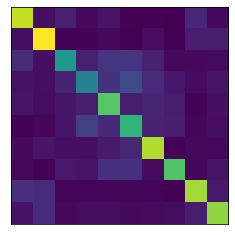

In [13]:
predictionArray = np.array(predictionArray)

def ensemble_classifier(predictionArray):
    
    pred_ensemble = []
    for i in range (10000):
        rows = predictionArray[:, i]
        m = stats.mode(rows) # getting the mode for all images (6 different classifiers)
        pred_ensemble.append(m[0][0]) 
        
    print('accuracy = ' + str(accuracy(np.transpose(pred_ensemble), testBatchLabels)))
    
    conf = confusion_matrix(testBatchLabels, pred_ensemble)
    plt.figure()
    plt.imshow(conf)
    plt.xticks([]), plt.yticks([])

# calling ensemble classifier
ensemble_classifier(predictionArray)

